In [12]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline
from arch import arch_model

In [3]:
# для выполнения ДЗ возьмем изначально нестационарный ряд (так интереснее)
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

#Напишем ф-ю для проверки стационарности ряда и его последовательного преобразования
def check_ts(df):
    series = df.iloc[:,1]
    tsplot(series)
    dftest = adfuller(series, autolag='AIC')
    if dftest[1] < 0.05:
        print('Как мы видим, тест Дики-Фуллера отвергает гипотезу о нестационарности ряда, ряд стационарен')
    else:
        print('Как мы видим, тест Дики-Фуллера не отвергает гипотезу о нестационарности ряда. Для начала уберем изменение дисперсии при помощи преобразования Бокса-Кокса')
        series = boxcox(series, 0)
        tsplot(series)
        dftest = adfuller(series, autolag='AIC')
        if dftest[1] < 0.05:
            print('При помощи Бокса-Кокса удалось добиться стационарности ряда, тест Дики-Фуллера отвергает гипотезу о нестационарности ряда')
        else:
            print('Нам удалось убрать размах дисперсии, но тест Дикки-Фуллера все еще не отвергает гипотезу о нестационарности ряда. По графику ряда видно наличие сильного тренда. Уберем его дифференцированием.')
            series = series[1:] - series[:-1]
            tsplot(series)
            dftest = adfuller(series, autolag='AIC')
            if dftest[1] < 0.05:
                print('При помощи дифференцирования удалось добиться стационарности ряда, тест Дики-Фуллера отвергает гипотезу о нестационарности ряда')
            else:
                print('Стало еще лучше, но по графику коррелограммы видно сильное влияние сезонности. Уберем ее')
                lag = dftest[2]
                series = series[lag:] - series[:-lag]
                tsplot(series)
                dftest = adfuller(series, autolag='AIC')
                if dftest[1] < 0.05:
                    print('Теперь тест Дики-Фуллера и графики коррелограмм отвергают гипотезу о нестационарности ряда!')
                else:
                    print('После всех доступных преобразований ряд остался нестационарным:(')
    print('__________________________________________________________________________________________')

Results of Dickey-Fuller Test:
Test Statistic                  -1.314625
p-value                          0.622455
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64
Как мы видим, тест Дики-Фуллера не отвергает гипотезу о нестационарности ряда. Для начала уберем изменение дисперсии при помощи преобразования Бокса-Кокса
Results of Dickey-Fuller Test:
Test Statistic                  -1.210369
p-value                          0.669119
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64
Нам удалось убрать размах дисперсии, но тест Дикки-Фуллера все еще не отвергает гипотезу о нестационарности ряда. По графику ряда видно наличие сильного тренда. Убер

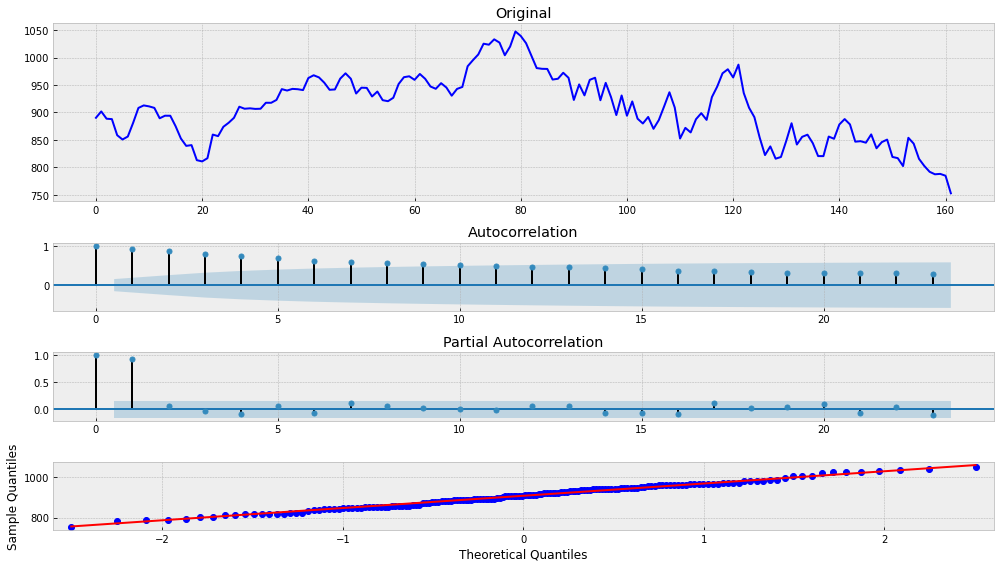

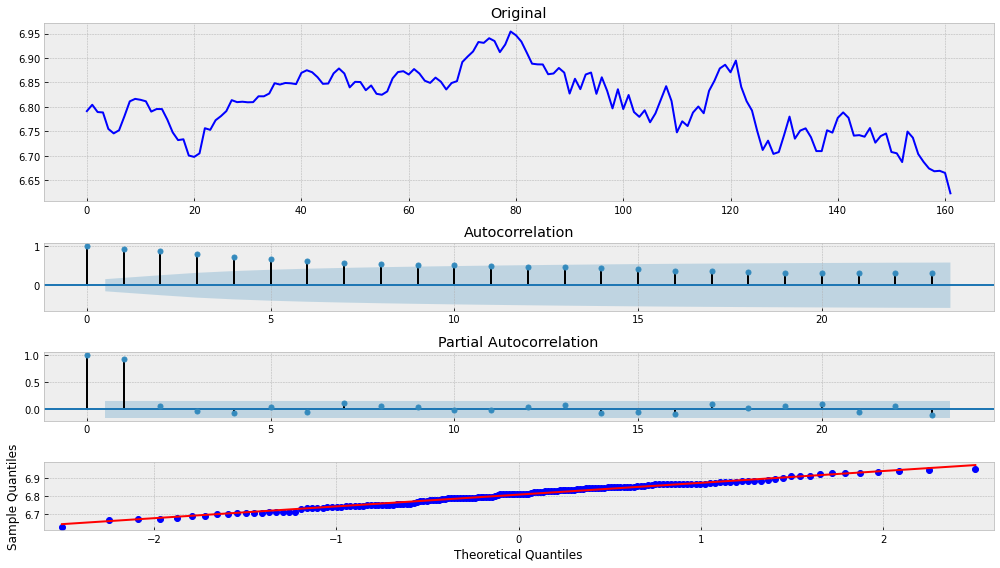

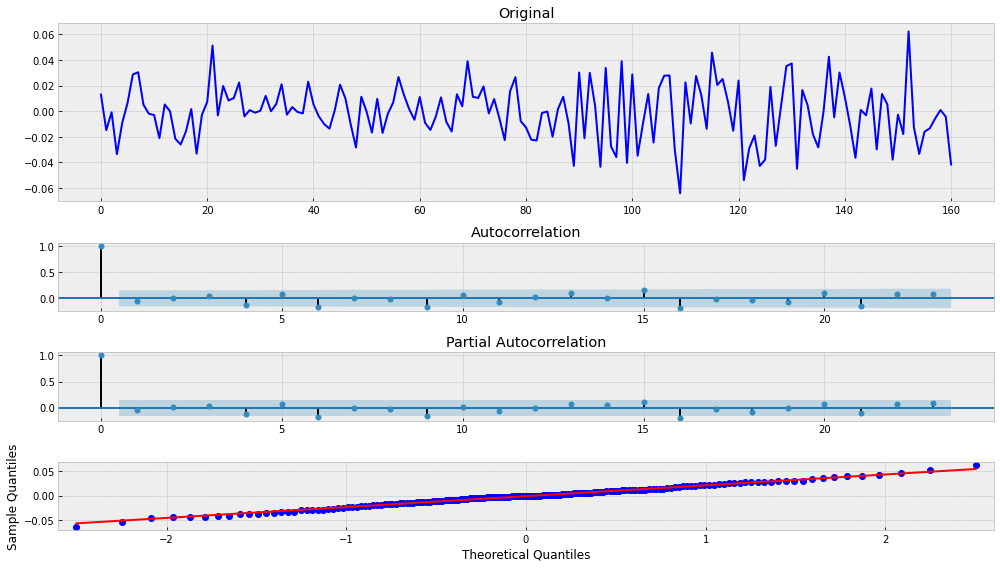

In [4]:
# Импортируем ряд из папки Series
dowjones_closing = pd.read_csv("weekly-closings-of-the-dowjones-.csv")
check_ts(dowjones_closing)

In [26]:
series = dowjones_closing['Close']

In [27]:
#применим преобразование Бокса-Кокса и дифференцирование (т.к. именно с их помощью ряд приводится к стационарности см. выше):
series = boxcox(series, 0)
series = series[1:] - series[:-1]

In [28]:
#Разобьем выборку на обучающую и тестовую:
train_count = int(round(len(series)*0.95,0))
train_count
train, test = series[:train_count], series[train_count:]

In [29]:
#Применим ARIMA к нашему временному ряду
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    for i in range(5):
        for d in range(5):
            for j in range(5):
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

aic, order, mdl = _get_best_model(train)

C:\Users\Vera_Romantsova\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Vera_Romantsova\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Vera_Romantsova\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Vera_Romantsova\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '
C:\Users\Vera_Romantsova\anaconda3\lib\site-packages\statsmodels\base

aic: -730.99254 | order: (2, 0, 3)


C:\Users\Vera_Romantsova\anaconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Results of Dickey-Fuller Test:
Test Statistic                -1.195367e+01
p-value                        4.258898e-22
#Lags Used                     0.000000e+00
Number of Observations Used    1.520000e+02
Critical Value (1%)           -3.474121e+00
Critical Value (5%)           -2.880750e+00
Critical Value (10%)          -2.577013e+00
dtype: float64


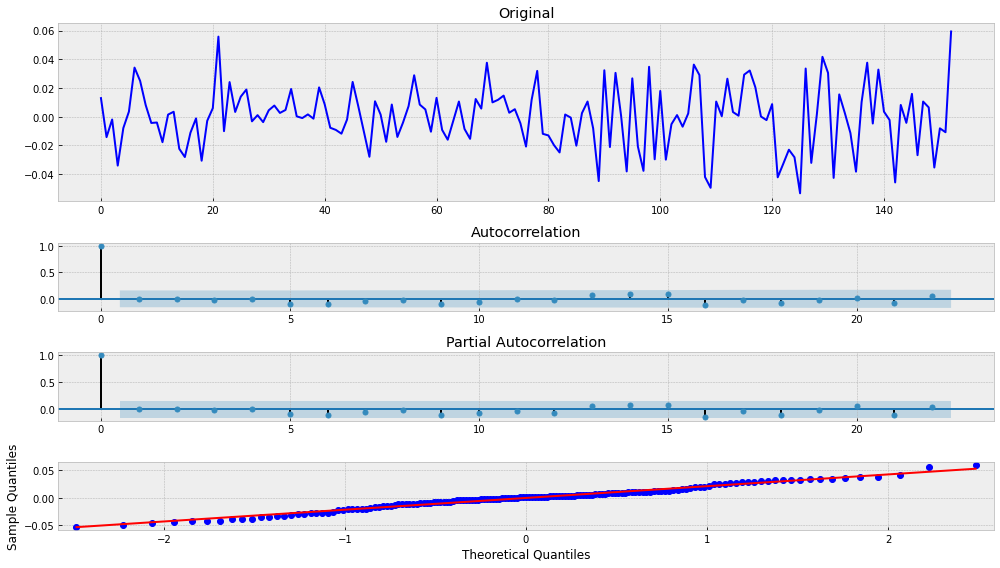

In [30]:
tsplot(mdl.resid)

In [32]:
#Применим GARCH с наилучшими найденными параметрами ARIMA
p_ = order[0]
o_ = order[1]
q_ = order[2]

#Использование Т-критерия обычно обеспечивает наилучшее обучение
am = arch_model(train, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

C:\Users\Vera_Romantsova\anaconda3\lib\site-packages\arch\univariate\base.py:316: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0004927. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                374.892
Distribution:      Standardized Student's t   AIC:                          -733.783
Method:                  Maximum Likelihood   BIC:                          -709.540
                                              No. Observations:                  153
Date:                      Fri, Jun 25 2021   Df Residuals:                      152
Time:                              13:01:54   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
m

Results of Dickey-Fuller Test:
Test Statistic                -1.259254e+01
p-value                        1.807921e-23
#Lags Used                     0.000000e+00
Number of Observations Used    1.520000e+02
Critical Value (1%)           -3.474121e+00
Critical Value (5%)           -2.880750e+00
Critical Value (10%)          -2.577013e+00
dtype: float64


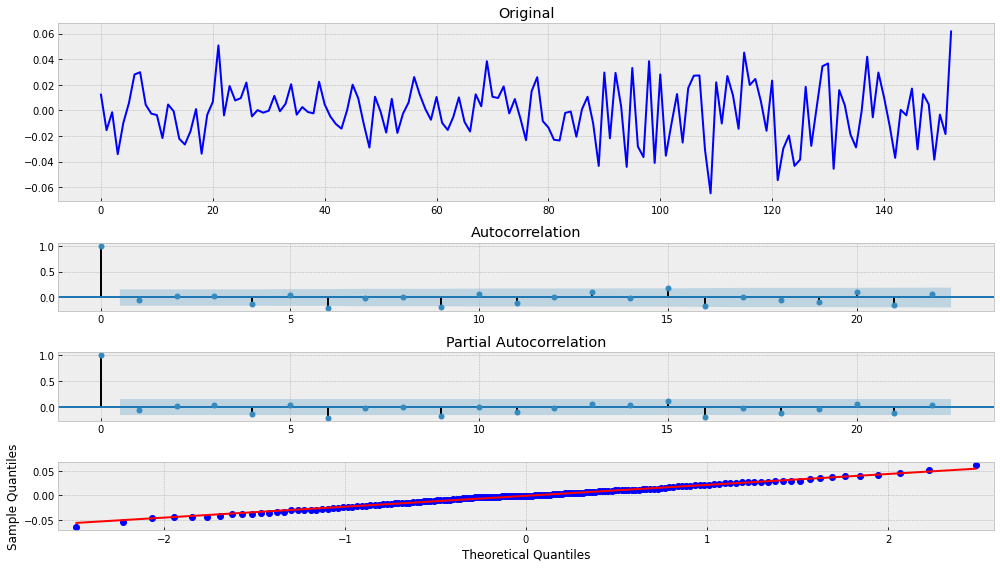

In [33]:
tsplot(res.resid)

In [34]:
#Прогноз GARCH на кол-во шагов, соответствующее тестовой выборке
pred = res.forecast(horizon=len(test), method='simulation', simulations=1000, reindex=False)
#соединим значения обучающей выборки и прогноза для тестовой выборки
forecast = train.copy()
forecast = np.concatenate((forecast, pred.variance.values[-1, :]))

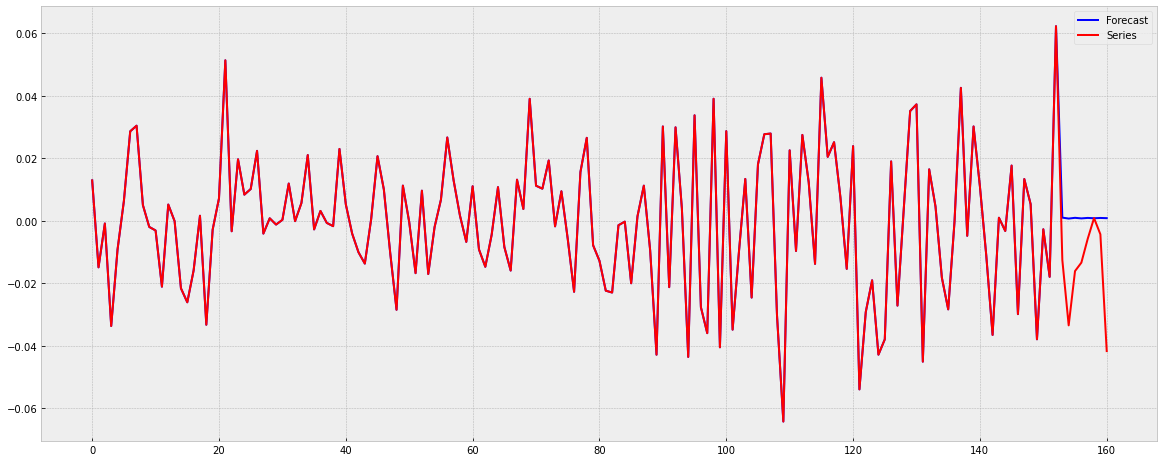

In [35]:
#Посмотрим на прогнозные и фактические значения на графике
with plt.style.context('bmh'):
    plt.figure(figsize=(20,8))
    ax = plt.axes()
    plt.plot(forecast, color='blue', label='Forecast')
    plt.plot(series, color='red', label='Series')
    plt.legend()
    plt.show()

In [ ]:
#так как цикличность ряда не слишком явная - возникли проблемы при прогнозировании ряда с помошью GARCH,
# вероятно - построение прогноза классическим ML даст более хорошие результаты

In [36]:
#Делаем прогноз классическим ML
series = pd.read_csv("weekly-closings-of-the-dowjones-.csv")
#Генерируем большое количество фичей для нашего временного ряда (прошлые 10 значений для каждого значения)
s = pd.DataFrame(series['Close'])
s.columns = ['curr_value']

window = 10
for i in range(1, window + 1):
    s.loc[:, f'prev_val_{i}'] = s['curr_value'].shift(i)

s.dropna(inplace=True)
s.head(5)

,curr_value,prev_val_1,prev_val_2,prev_val_3,prev_val_4,prev_val_5,prev_val_6,prev_val_7,prev_val_8,prev_val_9,prev_val_10
10,911.00,912.75,908.15,880.91,856.02,850.61,858.43,887.78,888.51,901.80,890.19
11,908.22,911.00,912.75,908.15,880.91,856.02,850.61,858.43,887.78,888.51,901.80
12,889.31,908.22,911.00,912.75,908.15,880.91,856.02,850.61,858.43,887.78,888.51
13,893.98,889.31,908.22,911.00,912.75,908.15,880.91,856.02,850.61,858.43,887.78
14,893.91,893.98,889.31,908.22,911.00,912.75,908.15,880.91,856.02,850.61,858.43


In [40]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):
    
    data = pd.DataFrame(data.copy())
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.Close.shift(i)
        
    data = data.dropna()
    data = data.reset_index(drop=True)
    data = data.drop(["Week"], axis=1)
     
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["Close"], axis=1)
    y_train = data.loc[:test_index]["Close"]
    X_test = data.loc[test_index:].drop(["Close"], axis=1)
    y_test = data.loc[test_index:]["Close"]
    
    return X_train, X_test, y_train, y_test

In [41]:
X_train, X_test, y_train, y_test = prepareData(dowjones_closing, lag_start=1, lag_end=20, test_size=0.3)

In [47]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)


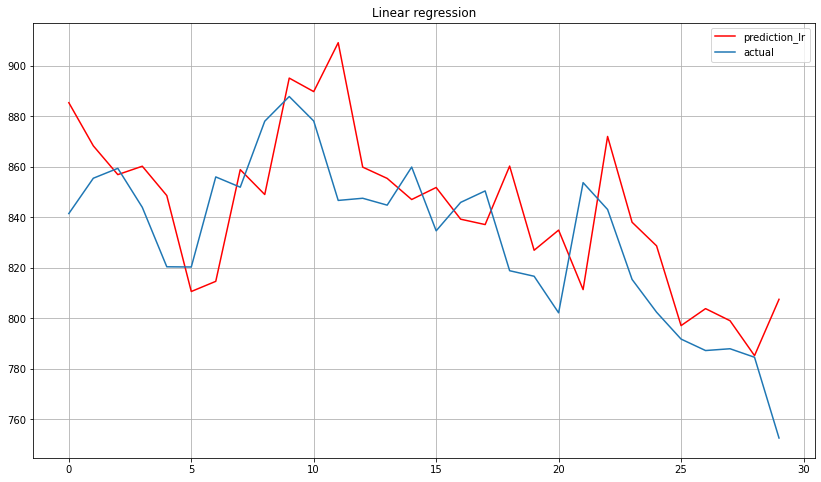

In [49]:
#Смотрим соответсвие прогноза регрессионной моделью к реальным значениям
plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction_lr")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True);

In [ ]:
#видно, что регрессионая модель описывает ряд лучше, при недостаточности прогноза - можно будет подобрать оптимальное кол-во 
# сгенерированных фич, варьируя их кол-во (в примере мы сделали только 10)